In [140]:
import torch
import rdkit
import rdkit.Chem as Chem
import networkx as nx
from hgraph.chemutils import *
from hgraph.nnutils import *
import numpy as np
from collections import Counter

In [190]:
# peptide = 'OC(C[C@@H](C(N[C@H](C(N[C@H](C(N[C@H](C(NCC(N[C@H](C(N[C@@]([H])([C@@H](C)CC)C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@H](C(N[C@@H](CC1=CC=CC=C1)C(N2CCC[C@H]2C(N[C@H](C(N[C@@]([C@H](O)C)(C(N[C@H](C(N[C@H](C(N[C@H](C(N[C@H](C(N[C@H](C(O)=O)CSC3)=O)CSCC3=O)=O)C(C)C)=O)CC4=CC=C(O)C=C4)=O)CC5=CNC6=C5C=CC=C6)=O)[H])=O)CO)=O)=O)=O)CCSC)=O)CCCCN[H])=O)=O)=O)CC7=CNC=N7)=O)=O)CCC(N)=O)=O)CCC(O)=O)=O)CS[H])=O)NC([C@@H](NC([C@@H](NC([C@H](C)NC(CN)=O)=O)CCCNC(N)=N)=O)CC(N)=O)=O)=O'
#c term proline
# peptide = 'N[C@@H]([C@]([H])(O)C)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](C(C)C)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC1=CN=C-N1)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CO)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS3)C(=O)N1[C@@H](CCC1)C(=O)O'
#n term proline
# peptide = 'N1[C@@H](CCC1)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](CS3)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CCCNC(=N)N)C(=O)O'
#random peptides
# peptide = 'N[C@@H]([H])C(=O)N[C@@H](CSCC(C4)=O)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS4)C(=O)N1[C@@H](CCC1)C(=O)O'
#peptide with no proline
peptide = 'N[C@@H]([C@]([H])(O)C)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](C)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CO)C(=O)O'

peptide = get_mol(peptide)

In [191]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

mol_with_atom_index(peptide)

Draw.MolToFile(peptide, "peptide.png",size=(6000,6000))

In [192]:
#separately define proline, because the backbone creates double recognition
proline = 'O=CC1CCCN1'
proline_matches = peptide.GetSubstructMatches(Chem.MolFromSmiles(proline),useChirality=True)
proline_matches

()

In [193]:
#find all amino acids
amino_acid_motif = 'NCC=O'
matches = peptide.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_motif),useChirality=True)
matches

((0, 1, 5, 6),
 (7, 8, 15, 16),
 (17, 18, 27, 28),
 (29, 30, 38, 39),
 (40, 41, 44, 45),
 (46, 47, 53, 54),
 (55, 56, 63, 64),
 (65, 66, 75, 76),
 (77, 78, 80, 81),
 (82, 83, 86, 87),
 (88, 89, 92, 93))

In [194]:
#get matches with overlapping nitrogens for cluster identification (this method will not get the C-terminal amino acid)
amino_acid_n = 'NCC(=O)N'
matches_n = peptide.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_n),useChirality=True)
matches_n = [match_n for match_n in matches_n]

#get matches with overlapping carboynl oxygens for cluster identification (this method will not get the N-terminal amino acid)
amino_acid_c = 'O=CCNC'
matches_c = peptide.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_c),useChirality=True)

#find matches that aren't prolines
if len(proline_matches) == 0:
    matches_without_prolines = matches
    matches_n_no_prolines = matches_n
    matches_c_no_prolines = matches_c
    backbone_atoms = np.hstack(np.unique(np.concatenate((np.hstack(matches_n_no_prolines),np.hstack(matches_c_no_prolines),np.hstack(peptide.GetSubstructMatches(Chem.MolFromSmiles('NCC(O)=O'),useChirality=True))))))
else:
    matches_without_prolines = [match for match in matches if not any([x in np.hstack(proline_matches) for x in match])]
    matches_n_no_prolines = [match for match in matches_n if sum([x in np.hstack(proline_matches) for x in match]) < 2]
    matches_c_no_prolines = [match for match in matches_c if sum([x in np.hstack(proline_matches) for x in match]) < 2]
    backbone_atoms = np.hstack(np.unique(np.concatenate((np.hstack(matches_n_no_prolines),np.hstack(matches_c_no_prolines),np.hstack(proline_matches),np.hstack(peptide.GetSubstructMatches(Chem.MolFromSmiles('NCC(O)=O'),useChirality=True))))))
backbone_atoms

array([ 0,  1,  5,  6,  7,  8, 15, 16, 17, 18, 27, 28, 29, 30, 38, 39, 40,
       41, 44, 45, 46, 47, 53, 54, 55, 56, 63, 64, 65, 66, 75, 76, 77, 78,
       80, 81, 82, 83, 86, 87, 88, 89, 92, 93, 94])

In [195]:
#split up side chain atoms and backbone atoms
sidechain_atoms = np.setdiff1d(np.array(range(1,peptide.GetNumAtoms())),backbone_atoms)
sidechain_atoms
# sidechain_atoms

array([ 2,  3,  4,  9, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 25, 26,
       31, 32, 33, 34, 35, 36, 37, 42, 43, 48, 49, 50, 51, 52, 57, 58, 59,
       60, 61, 62, 67, 68, 69, 70, 71, 72, 73, 74, 79, 84, 85, 90, 91])

In [196]:
matches_double_overlap = peptide.GetSubstructMatches(Chem.MolFromSmiles('NCC(NCC=O)=O'),useChirality=True)
matches_double_overlap = [m for m in matches_double_overlap if not any([x in sidechain_atoms for x in m])]
count = Counter(np.hstack(matches_double_overlap))
matches_double_overlap = [m for m in matches_double_overlap if not all(count[x] > 1 for x in m )]
if len(matches_double_overlap) == 2:
    n_terminus = [x for x in matches_double_overlap[0] if count[x] == 1]
    c_terminus = [x for x in matches_double_overlap[1] if count[x] == 1]
else:
    print('could not identify termini correctly')

In [197]:
#identify the termini clusters
#nterm cluster
if len(proline_matches) != 0:
    if any([x in np.hstack(proline_matches) for x in n_terminus]): #n_terminus is a proline
        n_terminus = [np.array(proline) for proline in proline_matches if any([x in n_terminus for x in proline])][0]
else: #n_terminus is not a proline
    n_terminus = [np.array(match) for match in matches if any([x in n_terminus for x in match])][0]
n_terminus


array([0, 1, 5, 6])

In [198]:
#cterm cluster
if len(proline_matches) != 0:
    if any([x in np.hstack(proline_matches) for x in c_terminus]):
        c_terminus = np.array(peptide.GetSubstructMatches(Chem.MolFromSmiles('CN1[C@H](C(O)=O)CCC1'),useChirality=True))[0]
else: #c terminus is not a proline
    c_terminus = np.array(peptide.GetSubstructMatches(Chem.MolFromSmiles('CNCC(=O)O'),useChirality=True))[0]
c_terminus

array([86, 88, 89, 92, 93, 94])

In [199]:
#non-terminus prolines
prolines_non_terminal = [proline for proline in proline_matches if not any([(x in c_terminus) or (x in n_terminus) for x in proline])]
if len(prolines_non_terminal) > 0:
    prolines_not_terminal_overlap = peptide.GetSubstructMatches(Chem.MolFromSmiles('O=CC1CCCN1C'),useChirality=True)
    prolines_not_terminal_overlap = [proline for proline in prolines_not_terminal_overlap if any([x in np.hstack(prolines_non_terminal) for x in proline])]
else:
    prolines_not_terminal_overlap = []
prolines_not_terminal_overlap

[]

In [217]:
clusters = list()
[clusters.append(match) for match in matches_c_no_prolines if sum([x in c_terminus for x in match]) < 2]
clusters.append(tuple(c_terminus))
clusters.append(tuple(n_terminus))
[clusters.append(proline) for proline in prolines_not_terminal_overlap]
clusters

[(16, 15, 8, 7, 5),
 (28, 27, 18, 17, 15),
 (39, 38, 30, 29, 27),
 (45, 44, 41, 40, 38),
 (54, 53, 47, 46, 44),
 (64, 63, 56, 55, 53),
 (76, 75, 66, 65, 63),
 (81, 80, 78, 77, 75),
 (87, 86, 83, 82, 80),
 (86, 88, 89, 92, 93, 94),
 (0, 1, 5, 6)]

In [218]:
c_alphas = np.array(matches)[:,1]
c_alphas_neighbors = [peptide.GetAtomWithIdx(int(x)).GetNeighbors() for x in c_alphas]
sidechain_atoms_with_calphas = np.union1d(sidechain_atoms,c_alphas)
# sidechain_atoms_with_calphas
backbone_atoms_without_calphas = np.setdiff1d(backbone_atoms,c_alphas)
# backbone_atoms_without_calphas
c_alphas

array([ 1,  8, 18, 30, 41, 47, 56, 66, 78, 83, 89])

In [219]:
##recursively identify alpha carbons, and map the atom indices that contain their side chains


for index,c_alpha in enumerate(c_alphas):
    c_alpha_neighbors = peptide.GetAtomWithIdx(int(c_alpha)).GetNeighbors()
    print('starting c_alpha atom index: ' + str(c_alpha))
    # print('neighbor indices: ' +str([neighbor.GetIdx() for neighbor in c_alpha_neighbors]))
    # print('neighbor atomic masses: ' + str([neighbor.GetAtomicNum() for neighbor in c_alpha_neighbors]))
    # print('starting atoms: ' + str([c_alpha_neighbor.GetIdx() for c_alpha_neighbor in c_alpha_neighbors]))
    # if c_alpha in c_terminus:
    #     print('c terminus skipped: ' + str(c_alpha))
    #     continue
    if len(proline_matches) != 0 :
        if c_alpha in np.hstack(proline_matches):
            print('skipped proline')
        continue
    for neighbor in c_alpha_neighbors:
        if (neighbor.GetIdx() not in backbone_atoms) and (neighbor.GetAtomicNum() == 6):
            # print('starting side chain atom: '+str(neighbor.GetIdx()) + ', atomic num: ' + str(neighbor.GetAtomicNum()))
            side_chain_atoms = np.array([neighbor.GetIdx()])
            new_neighbors = neighbor.GetNeighbors()
            # print('starting neighbor atom(s): ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]) + ', atomic num(s): ' + str([new_neighbor.GetAtomicNum() for new_neighbor in new_neighbors]))
            atoms_to_examine = np.array([])
            while(len(new_neighbors) > 0):
                for new_neighbor in new_neighbors:
                    if (new_neighbor.GetIdx() in c_alphas) and (new_neighbor.GetIdx() not in sidechain_atoms):
                        print('new stapled residue c_alpha atom found, index: ' + str(new_neighbor.GetIdx()))
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                    elif (new_neighbor.GetIdx() not in side_chain_atoms) and (new_neighbor.GetIdx() not in backbone_atoms):
                        # print('new neighbor atom found, index: ' + str(new_neighbor.GetIdx()))
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                        # print('side_chain_atom(s): ' + str(side_chain_atoms))
                        atoms_to_examine = np.append(atoms_to_examine,new_neighbor.GetIdx())
                        # print('atom(s) to examine: ' + str(atoms_to_examine))
                    elif new_neighbor.GetIdx()  in side_chain_atoms:
                        # print('already found this atom in side chain: ' + str(new_neighbor.GetIdx()))
                        continue
                    elif new_neighbor.GetIdx() in backbone_atoms:
                        # print('already found this atom in back bone: ' + str(new_neighbor.GetIdx()))
                        continue
                if len(atoms_to_examine) == 0:
                    # print('no new atoms to explore')
                    break
                else:
                    new_neighbors = np.hstack([peptide.GetAtomWithIdx(int(atom)).GetNeighbors() for atom in atoms_to_examine])
                    # print('new neighbors to investigate: ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]))
                    atoms_to_examine = np.array([])
            print('complete mapped side chain: ' + str([x for x in side_chain_atoms]))
            if sum([x in np.hstack(clusters) for x in side_chain_atoms]) < 3:
                clusters.append(tuple([x for x in side_chain_atoms]))

clusters
# [peptide.GetAtomWithIdx(x).GetNeighbors() for x in c_alphas]

starting c_alpha atom index: 1
new stapled residue c_alpha atom found, index: 1
complete mapped side chain: [2, 1, 3, 4]
starting c_alpha atom index: 8
new stapled residue c_alpha atom found, index: 8
new stapled residue c_alpha atom found, index: 41
complete mapped side chain: [9, 8, 10, 11, 12, 13, 14, 43, 42, 41]
starting c_alpha atom index: 18
new stapled residue c_alpha atom found, index: 18
complete mapped side chain: [19, 18, 20, 21, 26, 22, 25, 23, 24]
starting c_alpha atom index: 30
new stapled residue c_alpha atom found, index: 30
complete mapped side chain: [31, 30, 32, 33, 34, 35, 36, 37]
starting c_alpha atom index: 41
new stapled residue c_alpha atom found, index: 41
new stapled residue c_alpha atom found, index: 8
complete mapped side chain: [42, 41, 43, 13, 12, 11, 14, 10, 9, 8]
starting c_alpha atom index: 47
new stapled residue c_alpha atom found, index: 47
complete mapped side chain: [48, 47, 49, 50, 51, 52]
starting c_alpha atom index: 56
new stapled residue c_alpha

[(16, 15, 8, 7, 5),
 (28, 27, 18, 17, 15),
 (39, 38, 30, 29, 27),
 (45, 44, 41, 40, 38),
 (54, 53, 47, 46, 44),
 (64, 63, 56, 55, 53),
 (76, 75, 66, 65, 63),
 (81, 80, 78, 77, 75),
 (87, 86, 83, 82, 80),
 (86, 88, 89, 92, 93, 94),
 (0, 1, 5, 6),
 (2, 1, 3, 4),
 (9, 8, 10, 11, 12, 13, 14, 43, 42, 41),
 (19, 18, 20, 21, 26, 22, 25, 23, 24),
 (31, 30, 32, 33, 34, 35, 36, 37),
 (48, 47, 49, 50, 51, 52),
 (57, 56, 58, 59, 60, 61, 62, 85, 84, 83),
 (67, 66, 68, 69, 74, 70, 73, 71, 72),
 (79, 78),
 (90, 89, 91)]

In [220]:
#get atom_cls
atom_cls = [[] for i in range(len(peptide.GetAtoms()))]
for i in range(len(clusters)):
    for atom in clusters[i]:
        atom_cls[atom].append(i)
atom_cls

[[10],
 [10, 11],
 [11],
 [11],
 [11],
 [0, 10],
 [10],
 [0],
 [0, 12],
 [12],
 [12],
 [12],
 [12],
 [12],
 [12],
 [0, 1],
 [0],
 [1],
 [1, 13],
 [13],
 [13],
 [13],
 [13],
 [13],
 [13],
 [13],
 [13],
 [1, 2],
 [1],
 [2],
 [2, 14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [2, 3],
 [2],
 [3],
 [3, 12],
 [12],
 [12],
 [3, 4],
 [3],
 [4],
 [4, 15],
 [15],
 [15],
 [15],
 [15],
 [15],
 [4, 5],
 [4],
 [5],
 [5, 16],
 [16],
 [16],
 [16],
 [16],
 [16],
 [16],
 [5, 6],
 [5],
 [6],
 [6, 17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [6, 7],
 [6],
 [7],
 [7, 18],
 [18],
 [7, 8],
 [7],
 [8],
 [8, 16],
 [16],
 [16],
 [8, 9],
 [8],
 [9],
 [9, 19],
 [19],
 [19],
 [9],
 [9],
 [9]]

In [221]:
graph = nx.empty_graph( len(clusters) )
for atom, nei_cls in enumerate(atom_cls):
    if len(nei_cls) <= 1: continue
    bonds = [c for c in nei_cls if len(clusters[c]) == 2]
    rings = [c for c in nei_cls if len(clusters[c]) > 4] #need to change to 2

    if len(nei_cls) > 2 and len(bonds) >= 2:
        clusters.append([atom])
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)

    elif len(rings) > 2: #Bee Hives, len(nei_cls) > 2 
        clusters.append([atom]) #temporary value, need to change
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)
    else:
        for i,c1 in enumerate(nei_cls):
            for c2 in nei_cls[i + 1:]:
                inter = set(clusters[c1]) & set(clusters[c2])
                graph.add_edge(c1, c2, weight = len(inter))

n, m = len(graph.nodes), len(graph.edges)

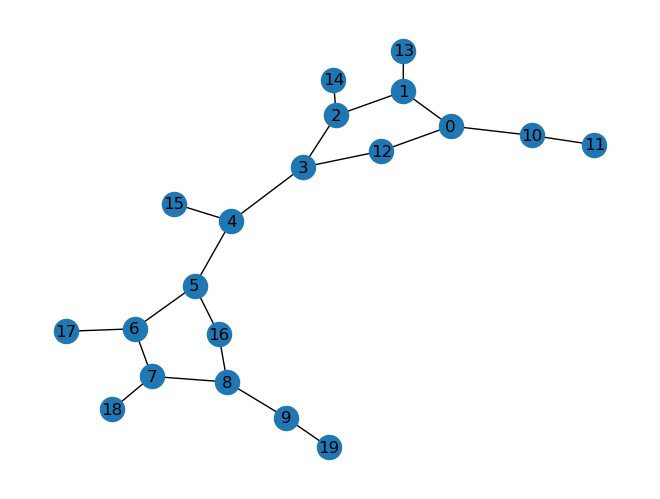

In [222]:
nx.draw(graph,with_labels=True)
plt.show()

In [223]:
n-m

-1

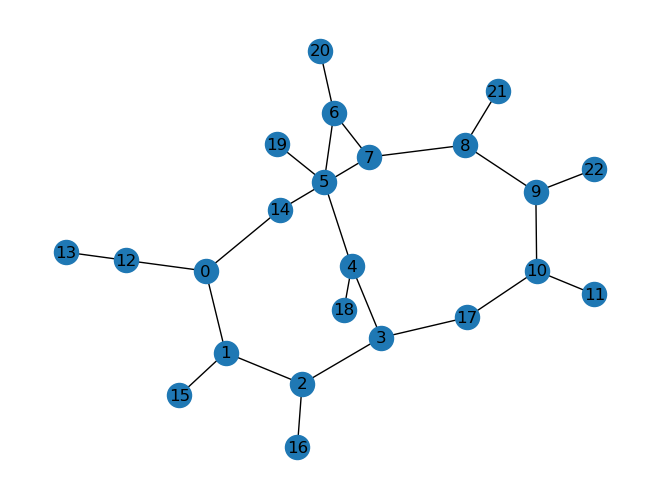

In [246]:
###putting it all together: one shot graph generation
peptide = 'N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@H](CC(=O)N)C(=O)N[C@@H](CSCC(C4)=O)C(=O)N[C@@H](CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCSC)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS4)C(=O)N1[C@@H](CCC1)C(=O)O'
mol = get_mol(peptide)
n_atoms = mol.GetNumAtoms()
if n_atoms == 1: #special case
    print('1 atom')

#separately define proline, because the backbone creates double recognition
proline = 'O=CC1CCCN1'
proline_matches = mol.GetSubstructMatches(Chem.MolFromSmiles(proline),useChirality=True)

#find all amino acids
amino_acid_motif = 'NCC=O'
matches = mol.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_motif),useChirality=True)

#get matches with overlapping nitrogens for cluster identification (this method will not get the C-terminal amino acid)
amino_acid_n = 'NCC(=O)N'
matches_n = mol.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_n),useChirality=True)
matches_n = [match_n for match_n in matches_n]

#get matches with overlapping carboynl oxygens for cluster identification (this method will not get the N-terminal amino acid)
amino_acid_c = 'O=CCNC'
matches_c = mol.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_c),useChirality=True)

#find matches that aren't prolines
if len(proline_matches) == 0:
    matches_without_prolines = matches
    matches_n_no_prolines = matches_n
    matches_c_no_prolines = matches_c
    backbone_atoms = np.hstack(np.unique(np.concatenate((np.hstack(matches_n_no_prolines),np.hstack(matches_c_no_prolines),np.hstack(mol.GetSubstructMatches(Chem.MolFromSmiles('NCC(O)=O'),useChirality=True))))))
else:
    matches_without_prolines = [match for match in matches if not any([x in np.hstack(proline_matches) for x in match])]
    matches_n_no_prolines = [match for match in matches_n if sum([x in np.hstack(proline_matches) for x in match]) < 2]
    matches_c_no_prolines = [match for match in matches_c if sum([x in np.hstack(proline_matches) for x in match]) < 2]
    backbone_atoms = np.hstack(np.unique(np.concatenate((np.hstack(matches_n_no_prolines),np.hstack(matches_c_no_prolines),np.hstack(proline_matches),np.hstack(mol.GetSubstructMatches(Chem.MolFromSmiles('NCC(O)=O'),useChirality=True))))))

#split up side chain atoms and backbone atoms
sidechain_atoms = np.setdiff1d(np.array(range(1,n_atoms)),backbone_atoms)

#identify the c and n terminus by finding where the amino acid backbone begins and ends
matches_double_overlap = mol.GetSubstructMatches(Chem.MolFromSmiles('NCC(NCC=O)=O'),useChirality=True)
matches_double_overlap = [m for m in matches_double_overlap if not any([x in sidechain_atoms for x in m])]
count = Counter(np.hstack(matches_double_overlap))
matches_double_overlap = [m for m in matches_double_overlap if not all(count[x] > 1 for x in m )]
if len(matches_double_overlap) == 2:
    n_terminus = [x for x in matches_double_overlap[0] if count[x] == 1]
    c_terminus = [x for x in matches_double_overlap[1] if count[x] == 1]
else:
    print('could not identify termini correctly')

#identify the termini clusters
#nterm cluster
if len(proline_matches) != 0:
    if any([x in np.hstack(proline_matches) for x in n_terminus]): #n_terminus is a proline
        n_terminus = [np.array(proline) for proline in proline_matches if any([x in n_terminus for x in proline])][0]
else: #n_terminus is not a proline
    n_terminus = [np.array(match) for match in matches if any([x in n_terminus for x in match])][0]

#cterm cluster
if len(proline_matches) != 0:
    if any([x in np.hstack(proline_matches) for x in c_terminus]):
        c_terminus = np.array(mol.GetSubstructMatches(Chem.MolFromSmiles('CN1[C@H](C(O)=O)CCC1'),useChirality=True))[0]
else: #c terminus is not a proline
    c_terminus = np.array(mol.GetSubstructMatches(Chem.MolFromSmiles('CNCC(=O)O'),useChirality=True))[0]

#non-terminus prolines
prolines_non_terminal = [proline for proline in proline_matches if not any([(x in c_terminus) or (x in n_terminus) for x in proline])]
if len(prolines_non_terminal) > 0:
    prolines_not_terminal_overlap = mol.GetSubstructMatches(Chem.MolFromSmiles('O=CC1CCCN1C'),useChirality=True)
    prolines_not_terminal_overlap = [proline for proline in prolines_not_terminal_overlap if any([x in np.hstack(prolines_non_terminal) for x in proline])]
else:
    prolines_not_terminal_overlap = []

#define clusters from backbones, the termini, and any prolines
clusters = list()
[clusters.append(match) for match in matches_c_no_prolines if sum([x in c_terminus for x in match]) < 2]
clusters.append(tuple(c_terminus))
clusters.append(tuple(n_terminus))
[clusters.append(proline) for proline in prolines_not_terminal_overlap]

#define alpha carbons and sets of backbone/ sideatoms without and with them
c_alphas = np.array(matches)[:,1]
c_alphas_neighbors = [mol.GetAtomWithIdx(int(x)).GetNeighbors() for x in c_alphas]
sidechain_atoms_with_calphas = np.union1d(sidechain_atoms,c_alphas)
backbone_atoms_without_calphas = np.setdiff1d(backbone_atoms,c_alphas)

##recursively identify alpha carbons, and map the atom indices that contain their side chains
for index,c_alpha in enumerate(c_alphas): #iterate throguh each alpha carbon
    c_alpha_neighbors = mol.GetAtomWithIdx(int(c_alpha)).GetNeighbors() #get the neighbors of given c_alpha. serves as starting point for molecular search
    if len(proline_matches) != 0 :
        if c_alpha in np.hstack(proline_matches):
            continue
    for neighbor in c_alpha_neighbors: #for each atom next to a c_alpha, traverse it if it's not a backbone atom and it's also a carbon
        if (neighbor.GetIdx() not in backbone_atoms) and (neighbor.GetAtomicNum() == 6):
            side_chain_atoms = np.array([neighbor.GetIdx()]) #define the side chain of this c_alpha as a set, starting over at each new c_alpha
            new_neighbors = neighbor.GetNeighbors() # atoms to explore
            atoms_to_examine = np.array([]) #next atoms to explore
            while(len(new_neighbors) > 0): #if there are new neighbors from the previous step, proceed with side chain traversal
                for new_neighbor in new_neighbors:
                    if (new_neighbor.GetIdx() in c_alphas) and (new_neighbor.GetIdx() not in sidechain_atoms): #if the next atom is a c_alpha, include it (this works for non-stapled and stapled residues)
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                    elif (new_neighbor.GetIdx() not in side_chain_atoms) and (new_neighbor.GetIdx() not in backbone_atoms): #if it's a regular side chain, add it, and all the new neighbors
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                        atoms_to_examine = np.append(atoms_to_examine,new_neighbor.GetIdx())
                    elif new_neighbor.GetIdx()  in side_chain_atoms: #skip previously explored side chain atoms
                        continue
                    elif new_neighbor.GetIdx() in backbone_atoms: #skip previously explored backbone atoms
                        continue
                if len(atoms_to_examine) == 0: #if there's no more atoms to examine, end traversal
                    break
                else:
                    new_neighbors = np.hstack([mol.GetAtomWithIdx(int(atom)).GetNeighbors() for atom in atoms_to_examine]) #define the next step of neighbors as the atoms to examine
                    atoms_to_examine = np.array([])
            if sum([x in np.hstack(clusters) for x in side_chain_atoms]) < 3: #if most of this side chain has already been added as a cluster, do not add it (this commonly happens when a stapled side chain is traversed from both sides)
                clusters.append(tuple([x for x in side_chain_atoms]))

#convert cluster atoms to int
cluster = [tuple([int(atom) for atom in cluster]) for cluster in clusters]


#for each atom in the molecule, find which clusters it's a part of
atom_cls = [[] for i in range(n_atoms)]
for i in range(len(clusters)):
    for atom in clusters[i]:
        atom_cls[int(atom)].append(i)
        
#draw graph
graph = nx.empty_graph( len(clusters) )
for atom, nei_cls in enumerate(atom_cls):
    if len(nei_cls) <= 1: continue
    bonds = [c for c in nei_cls if len(clusters[c]) == 2]
    rings = [c for c in nei_cls if len(clusters[c]) > 4] #need to change to 2

    if len(nei_cls) > 2 and len(bonds) >= 2:
        clusters.append([atom])
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)

    elif len(rings) > 2: #Bee Hives, len(nei_cls) > 2 
        clusters.append([atom]) #temporary value, need to change
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)
    else:
        for i,c1 in enumerate(nei_cls):
            for c2 in nei_cls[i + 1:]:
                inter = set(clusters[c1]) & set(clusters[c2])
                graph.add_edge(c1, c2, weight = len(inter))

n, m = len(graph.nodes), len(graph.edges)
nx.draw(graph,with_labels=True)
plt.show()

In [245]:
[tuple([int(atom) for atom in cluster]) for cluster in clusters]

[(21, 20, 13, 12, 10),
 (35, 34, 23, 22, 20),
 (43, 42, 37, 36, 34),
 (53, 52, 45, 44, 42),
 (67, 66, 55, 54, 52),
 (73, 72, 69, 68, 66),
 (81, 80, 75, 74, 72),
 (87, 86, 83, 82, 80),
 (96, 95, 89, 88, 86),
 (107, 106, 98, 97, 95),
 (113, 112, 109, 108, 106),
 (112, 114, 115, 119, 121, 120, 116, 117, 118),
 (0, 1, 10, 11),
 (2, 1, 3, 4, 9, 5, 8, 6, 7),
 (14, 13, 15, 16, 17, 18, 19, 85, 84, 83),
 (24, 23, 25, 26, 28, 27, 29, 33, 30, 32, 31),
 (38, 37, 39, 40, 41),
 (46, 45, 47, 48, 49, 50, 51, 111, 110, 109),
 (56, 55, 57, 58, 60, 59, 61, 65, 62, 64, 63),
 (70, 69, 71),
 (76, 75, 77, 78, 79),
 (90, 89, 91, 92, 93, 94),
 (99, 98, 100, 101, 102, 103, 104, 105)]